In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import textacy

In [2]:
import os
import codecs

data_directory = os.path.join('.', 'data')

raw_excel_filepath = os.path.join(data_directory,
                                   'Maintenance_All_Clean.xlsx')
sheet = "Sheet1"

df = pd.read_excel(raw_excel_filepath, sheetname=sheet)
print df.shape
df.head()

(3435, 7)


,Date,Mach type,Mach,Effect,Machine Area,Description,Resolution
0,2015-01-11,NaN,H27,NaN,NaN,Broken bar feeder chain,Repaired
1,2015-01-14,NaN,H5,NaN,NaN,No power,Replaced pin in pendant and powered machine; P...
2,2015-02-27,NaN,QA,NaN,NaN,Smartscope harness broken,Parts ordered / Tech repaired
3,2015-02-27,NaN,H18,NaN,NaN,Check / Charge Accumulators,Where OK
4,2015-02-27,NaN,H23,NaN,NaN,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...


In [3]:
# deal with sparse labeling (Effect Column)

df[["Effect", "Machine Area"]] = df[["Effect", "Machine Area"]].fillna(value="NaN")
# print df["Machine Area"].value_counts()

df['labels'] = df["Machine Area"]
min_count = 3 # Filter labels occuring less than this

value_counts = df["labels"].value_counts() # Specific column 
to_remove = value_counts[value_counts < min_count].index
df['labels'].replace(to_remove, 'MISC', inplace=True)
df["labels"] = df["labels"].astype('category')
# df["labels"][df["labels"]!=-1] = df["labels"][df["labels"]!=-1].cat.codes

from sklearn.preprocessing import LabelEncoder
area_labeler = LabelEncoder()
df["labels"] = area_labeler.fit_transform(df["labels"])

df["labels"].value_counts()

39    2760
35      69
29      57
16      37
0       31
38      30
4       29
48      26
6       24
9       23
47      20
14      18
53      18
22      17
45      16
10      15
40      14
31      13
52      12
3       12
55      12
32      11
43       9
19       9
51       8
5        7
11       7
12       6
33       6
18       6
42       6
34       6
21       6
49       6
24       6
37       5
44       5
54       5
27       5
8        5
15       5
28       4
56       4
30       4
1        4
17       4
26       3
36       3
20       3
25       3
46       3
41       3
23       3
50       3
7        3
2        3
13       3
Name: labels, dtype: int64

In [4]:
missing_label = df['labels'].value_counts().argmax()
df["labels"][df["labels"]==missing_label] = -1  # to make a "non-category"
df["labels"][df["labels"]>missing_label] = df["labels"][df["labels"]>missing_label].values - 1  # shift higher cats down. 

old_encode = lambda x: np.where(x>missing_label, x+1, x)  # so that we can undo this ungodly frankensteining later

df["labels"].value_counts()

C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


-1     2760
 35      69
 29      57
 16      37
 0       31
 38      30
 4       29
 47      26
 6       24
 9       23
 46      20
 52      18
 14      18
 22      17
 44      16
 10      15
 39      14
 31      13
 51      12
 54      12
 3       12
 32      11
 19       9
 42       9
 50       8
 5        7
 11       7
 48       6
 41       6
 34       6
 33       6
 18       6
 21       6
 12       6
 24       6
 8        5
 27       5
 43       5
 15       5
 37       5
 53       5
 28       4
 55       4
 30       4
 1        4
 17       4
 26       3
 36       3
 20       3
 40       3
 7        3
 13       3
 23       3
 25       3
 49       3
 2        3
 45       3
Name: labels, dtype: int64

In [5]:
df.head()

,Date,Mach type,Mach,Effect,Machine Area,Description,Resolution,labels
0,2015-01-11,NaN,H27,NaN,NaN,Broken bar feeder chain,Repaired,-1
1,2015-01-14,NaN,H5,NaN,NaN,No power,Replaced pin in pendant and powered machine; P...,-1
2,2015-02-27,NaN,QA,NaN,NaN,Smartscope harness broken,Parts ordered / Tech repaired,-1
3,2015-02-27,NaN,H18,NaN,NaN,Check / Charge Accumulators,Where OK,-1
4,2015-02-27,NaN,H23,NaN,NaN,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...,-1


In [6]:
raw_csv_filepath = os.path.join(data_directory,
                                   'raw_csv_logs.csv')
# if not os.path.isfile(raw_csv_filepath): 
df.to_csv(raw_csv_filepath, encoding='utf-8', header=False)
    
# intermediate_directory = os.path.join('.', 'intermediate')

In [7]:
docs = textacy.fileio.read.read_csv(raw_csv_filepath, encoding='utf-8')

content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 6)  # Descriptions in Col 6
corpus = textacy.Corpus(u'en', texts=content_stream, metadatas=metadata_stream)

corpus

Corpus(3435 docs; 19565 tokens)

In [8]:
#-----For NMF-----#
doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
    (doc.to_terms_list(ngrams=(1,2,3), 
                       normalize=u'lemma',
                       named_entities=True, 
                       filter_stops=True,
                       filter_punct=True,
                       as_strings=True)
     for doc in corpus),
    weighting='tfidf', 
    normalize=True, 
    smooth_idf=True, 
    min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

# tfidf_embedding = np.copy(doc_term_matrix)

# model = textacy.tm.TopicModel('nmf', n_topics=50)
# model.fit(doc_term_matrix)
# doc_topic_matrix = model.transform(doc_term_matrix)

#-----------------#
#-----For LDA-----#
doc_term_matrix_TF, id2term_TF = textacy.vsm.doc_term_matrix(
    (doc.to_terms_list(ngrams=(1,2,3), 
                       normalize=u'lemma',
                       named_entities=True, 
                       filter_stops=True,
                       filter_punct=True,
                       as_strings=True)
     for doc in corpus),
    weighting='tf', 
    normalize=False, 
    smooth_idf=False, 
    min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

# tf_embedding = np.copy(doc_term_matrix)
# # model = textacy.tm.TopicModel('nmf', n_topics=20)
# model = textacy.tm.TopicModel('lda', n_topics=50)
# model.fit(doc_term_matrix)
# doc_topic_matrix = model.transform(doc_term_matrix)
#-----------------#

print(repr(doc_term_matrix))

<3435x2492 sparse matrix of type '<type 'numpy.float64'>'
	with 20419 stored elements in Compressed Sparse Row format>


In [9]:
model = textacy.tm.TopicModel('nmf', n_topics=30)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)


LDA_model = textacy.tm.TopicModel('lda', n_topics=30)
LDA_model.fit(doc_term_matrix_TF)
doc_topic_matrix_LDA = LDA_model.transform(doc_term_matrix_TF)


LSA_model = textacy.tm.TopicModel('lsa', n_topics=300)
LSA_model.fit(doc_term_matrix)
doc_topic_matrix_LSA = LSA_model.transform(doc_term_matrix)

In [10]:
print "Doc. Matrix Shape: ",doc_topic_matrix.shape

for topic_idx, top_terms in model.top_topic_terms(id2term, top_n=7):
    print('topic', topic_idx, ':', '   '.join(top_terms))

Doc. Matrix Shape:  (3435L, 30L)
('topic', 0, ':', u'accumulator check   check request   accumulator check request   request   accumulator   check   saw')
('topic', 1, ':', u'conveyor   chip   chip conveyor   jam   conveyor jam   chip conveyor jam   conveyor inop')
('topic', 2, ':', u'hydraulic   hydraulic leak   leak   major hydraulic leak   major hydraulic   major   b')
('topic', 3, ':', u'inop   conveyor inop   chip conveyor inop   unit inop   pump inop   conveyor   brush unit inop')
('topic', 4, ':', u'unit   brush   brush unit   unit inop   brush unit inop   motor   return')
('topic', 5, ':', u'loader   bar   bar loader   feed   loader chain   loader fault   issue')
('topic', 6, ':', u'base   clean   base clean   clean request   base clean request   request   clean base')
('topic', 7, ':', u'coolant   pump   coolant pump   flow   coolant flow   pump inop   coolant pump inop')
('topic', 8, ':', u'vogel   lube   vogel lube   lube fault   vogel lube fault   fault   vogel fault')
('to

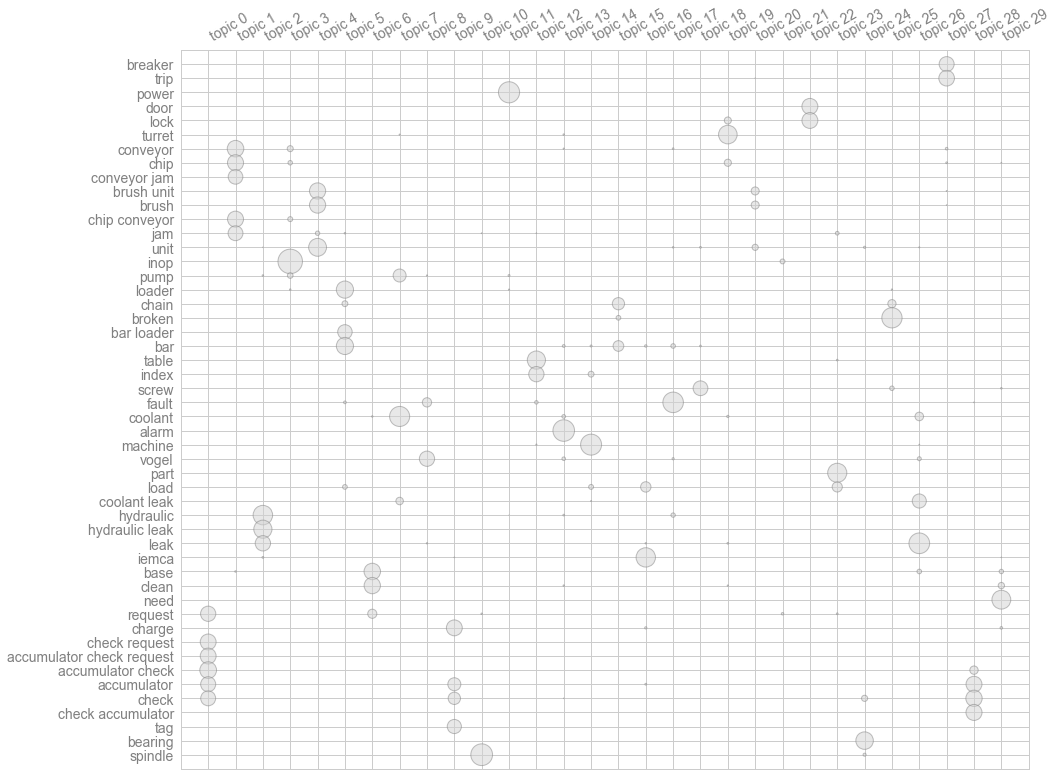

In [11]:
model.termite_plot(doc_topic_matrix, id2term, n_terms=50, sort_terms_by='seriation')

In [12]:
print "Doc. Matrix Shape: ",doc_topic_matrix_LDA.shape

for topic_idx, top_terms in LDA_model.top_topic_terms(id2term_TF, top_n=7):
    print('topic', topic_idx, ':', '   '.join(top_terms))

Doc. Matrix Shape:  (3435L, 30L)
('topic', 0, ':', u'fuse   hyd flange   stem   safety guard   remount   unit safety guard   unit safety')
('topic', 1, ':', u'breaker   trip   clutch   swap   trip breaker   spindle   pick')
('topic', 2, ':', u'inop   st#2   collet   drill   detector   tool   station')
('topic', 3, ':', u'fault   vogel   pressure   lube   vogel lube   o/t   housing')
('topic', 4, ':', u'stock   dog   go   hit   id   get   truck')
('topic', 5, ':', u'coolant   leak   oil   low   air   hp   flow')
('topic', 6, ':', u'iemca   cut   st#5   motor   unit   bolt   fee')
('topic', 7, ':', u'cnc   line   filter   come   hydraulics   home   air')
('topic', 8, ':', u'replace   need   control   4   axis   spindle   new')
('topic', 9, ':', u'2   unit   1   stick   brush unit   brush   stop')
('topic', 10, ':', u'saw   bad   rebuild   short   spin   attachment   p/o')
('topic', 11, ':', u'motor   shut   start   wire   machine   not   hot')
('topic', 12, ':', u'table   index   sensor 

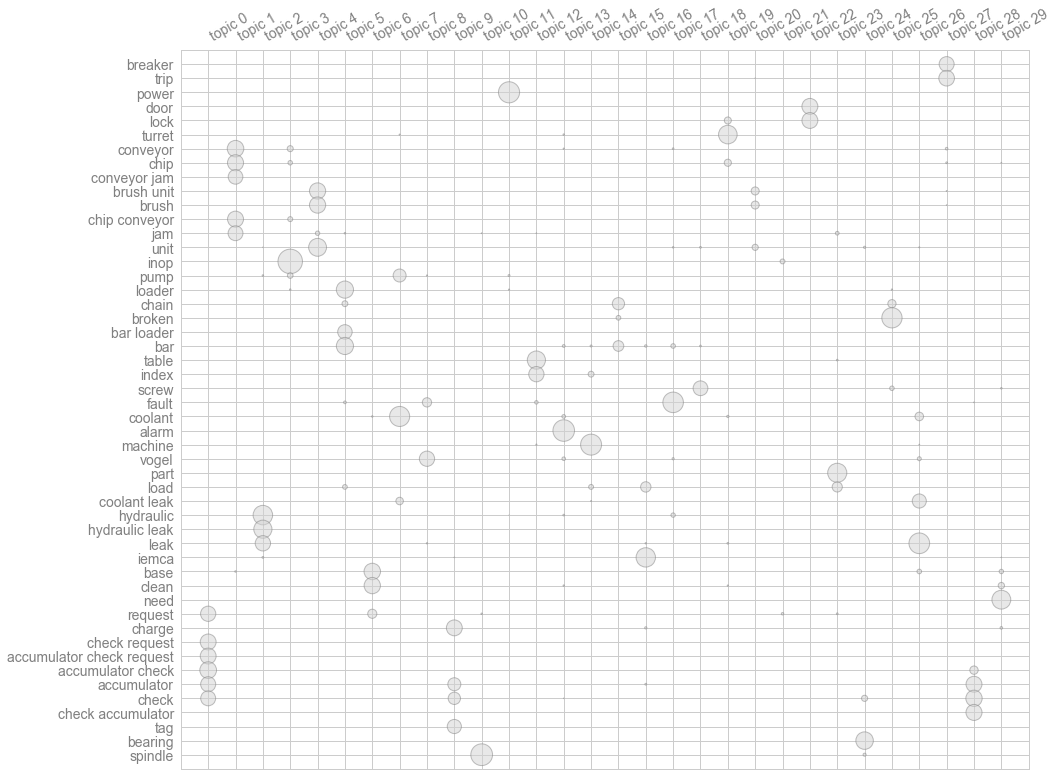

In [13]:
model.termite_plot(doc_topic_matrix, id2term, n_terms=50, sort_terms_by='seriation')

In [14]:
top_term_matrix = LDA_model.model.components_
doc_lengths = [len(d) for d in corpus]
vocab = list(id2term_TF.values())
term_frequency = textacy.vsm.get_term_freqs(doc_term_matrix_TF)

import pyLDAvis
pyLDAvis.enable_notebook()

# normalize(doc_topic_matrix, norm='l1').sum(axis=1).shape

In [15]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
from sklearn.preprocessing import normalize

vis_data = pyLDAvis.prepare(
    top_term_matrix,
    doc_topic_matrix_LDA,
    doc_lengths,
    vocab,
    term_frequency,
)

In [16]:
pyLDAvis.display(vis_data)

In [17]:
w2v_embed = corpus.vectors
print w2v_embed.shape

nmf_embed = np.copy(doc_topic_matrix)
print nmf_embed.shape

lda_embed = np.copy(doc_topic_matrix_LDA)
print lda_embed.shape

lsa_embed = np.copy(doc_topic_matrix_LSA)
print lsa_embed.shape

(3435L, 300L)
(3435L, 30L)
(3435L, 30L)
(3435L, 300L)


In [18]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, label_propagation  
w2v_label_prop = LabelSpreading(kernel='knn', n_neighbors=20)
# w2v_label_prop = LabelSpreading(kernel='rbf', gamma=10)
w2v_label_prop.fit(w2v_embed, df["labels"])
print "done w/w2v, computing nmf\n..."

nmf_label_prop = LabelSpreading(kernel='knn', n_neighbors=20)
# nmf_label_prop = LabelSpreading(kernel='rbf', gamma=10)
nmf_label_prop.fit(nmf_embed, df["labels"])
print "done w/nmf, computing nmf\n..."

lda_label_prop = LabelSpreading(kernel='knn', n_neighbors=20)
# lda_label_prop = LabelSpreading(kernel='rbf', gamma=10)
lda_label_prop.fit(lda_embed, df["labels"])
print "done w/lda\n_____"

done w/w2v, computing nmf
...


C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\semi_supervised\label_propagation.py:267: RuntimeWarning: invalid value encountered in divide
  self.label_distributions_ /= normalizer


done w/nmf, computing nmf
...
done w/lda
_____


In [19]:
df["W2V_PredictedArea"] = area_labeler.inverse_transform(old_encode(w2v_label_prop.transduction_))
df["NMF_PredictedArea"] = area_labeler.inverse_transform(old_encode(nmf_label_prop.transduction_))
df["LDA_PredictedArea"] = area_labeler.inverse_transform(old_encode(lda_label_prop.transduction_))
df[["Description", "W2V_PredictedArea", "NMF_PredictedArea", "LDA_PredictedArea"]]

,Description,W2V_PredictedArea,NMF_PredictedArea,LDA_PredictedArea
0,Broken bar feeder chain,Bar,Bar,Bar
1,No power,Electrical,Power Pack,Electrical
2,Smartscope harness broken,Screw,Bolt,Axis
3,Check / Charge Accumulators,Hydraulic System,Accumulator,Accumulator
4,Hyd leak at saw atachment,Hydraulic System,NaN,Tumbler
5,CS1008 setup change over / from ARC1004,Collet,Spindle,MISC
6,Gears on saw attachment tight and grinding per...,Collet,Saw,Chip Guard
7,Check and charge Accumulators,Hydraulic System,Accumulator,Accumulator
8,St# 14 milling spindle repairs,Bearings,Spindle,Brush Unit
9,Hydraulic leak,Hydraulic System,Hydraulic System,Hydraulic System


In [62]:
df[["Description", "W2V_PredictedArea", "NMF_PredictedArea", "LDA_PredictedArea"]].to_excel("propagated_labels_W2V-NMF-LDA_022317.xlsx")

In [44]:

df_counts = pd.DataFrame(data={"W2V_PredictedArea":df["W2V_PredictedArea"].value_counts(), 
                               "NMF_PredictedArea":df["NMF_PredictedArea"].value_counts(), 
                               "LDA_PredictedArea":df["LDA_PredictedArea"].value_counts()})
df_counts.head()
# sns.countplot(data=df_counts)
# df[["W2V_PredictedArea", "NMF_PredictedArea", "LDA_PredictedArea"]].plot(kind='barh')

,LDA_PredictedArea,NMF_PredictedArea,W2V_PredictedArea
Accumulator,182,359,149
Actuator,4,12,9
Air System,3,4,5
Axis,121,75,35
Bar,193,151,289


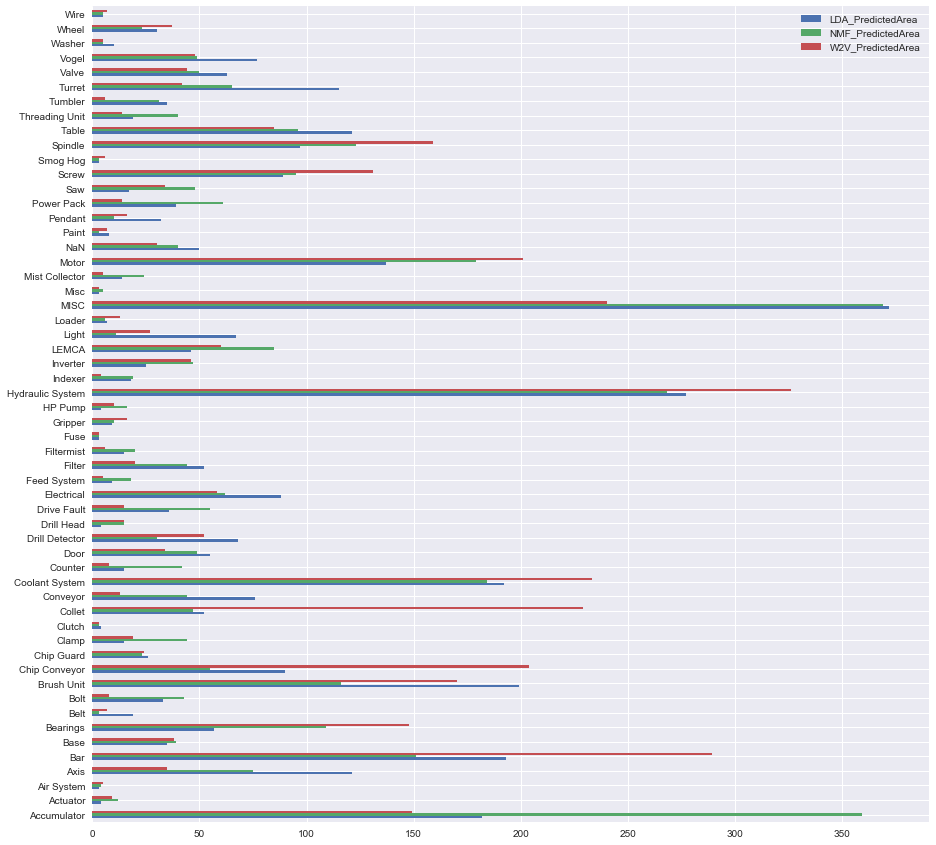

In [45]:
df_counts.plot(kind='barh', figsize=(15,15))

In [58]:
import scipy.stats as stats
# compute the entropies of transduced label distributions
pred_entropies = stats.distributions.entropy(
    w2v_label_prop.label_distributions_.T)

    # select five digit examples that the classifier is most uncertain about
uncertainty_index = np.argsort(pred_entropies)[-25:]

In [59]:
df[["Description","W2V_PredictedArea"]].loc[uncertainty_index]

,Description,W2V_PredictedArea
1196,Table index prox cables falling out of sensor,LEMCA
2866,Electrical connection seal tites broken; Safety,Screw
1412,Damaged cable for gripper jaws OPEN sensor,Screw
1207,Bar gripper clamp (on loader) spring broken,Hydraulic System
2023,Valve connections swapped on 3rd shift; Lines ...,Wheel
3169,XD unit running hot,Bearings
1343,Bar loader issues (??),Brush Unit
396,Side 1 gate repiar,Electrical
907,Missing St#4 valve (Removed on 3rd for St#11 H38),Hydraulic System
3116,Operator reporting feed tubes excessively hot;...,Coolant System


In [22]:
# obama_docs = list(corpus.get(
#     lambda doc: doc.metadata['speaker_name'] == 'Barack Obama'))
# print len(obama_docs)

doc = corpus[-1]
doc

Doc(7 tokens; "Hydraulic leak from regulation wheel control va...")

In [144]:
pattern = textacy.constants.POS_REGEX_PATTERNS['en']['NP']
print pattern

for doc in corpus[:20]:
    print list(textacy.extract.pos_regex_matches(doc, pattern))

<DET>? <NUM>* (<ADJ> <PUNCT>? <CONJ>?)* (<NOUN>|<PROPN> <PART>?)+
[Broken bar feeder chain]
[No power]
[Smartscope harness]
[Check, Charge Accumulators]
[Hyd leak, atachment]
[CS1008 setup change, ARC1004]
[Gears, attachment, Alex]
[Check, charge Accumulators]
[St, 14 milling spindle repairs]
[Hydraulic leak]
[Turrets, A, B]
[Spindle carrier, Feed]
[PO]
[drill]
[Accumulator check]
[Conveyor Jam]
[Hydraulic Motor, Alarm]
[Smog Hog]
[Bar loader tray bent, forktruck]
[Transport, parts]


In [24]:
for doc in corpus:
    sov= list(textacy.extract.subject_verb_object_triples(doc))
    if len(sov)>0:
        print sov

[(Hyd leak, saw, atachment)]
[(Gears, saw, attachment)]
[(Hydraulic Motor, overheat, Alarm)]
[(Saw attachment, saw, life), (short, saw, life)]
[(Saw attachment, saw, life), (short, saw, life)]
[(St#11 spindle, keeps, losing)]
[(Machine, will not stay, running)]
[(Accumulator, check, parts)]
[(Breaker, elect, burn smell)]
[(Stop, switch, S120.2)]
[(power switch, will not shift, ON), (power switch, will not shift, OFF)]
[(Emergency, retract, failure)]
[(Invert, push, rod)]
[(Spindle, clamp, alarms)]
[(Contoler, keeps, resetting)]
[(Saw unit, needs, to be replaced)]
[(Hyd, will not pick, part)]
[(Hydraulic Main Fault, will not build, pressure)]
[(Hydraulic valve stack, has, vibration)]
[(Rear, lock, alarm faults)]
[(St#7, will not complete, cycle)]
[(Base, has, fluid)]
[(Monitor spindle, drive, fault)]
[(Brushing, requires, LH rotation)]
[(slide, rolls, spindle)]
[(Loader, will not insert, part)]
[(Gates, need, repair), (latches, need, repair)]
[(HP oil intake, needs, to be extended), (HP

In [75]:
textacy.keyterms.textrank(corpus, n_keyterms=10)

AttributeError: 'Doc' object has no attribute 'lemma_'

In [74]:
textacy.text_stats.readability_stats(doc)

{u'automated_readability_index': 11.675714285714285,
 u'coleman_liau_index': 16.931505142857148,
 u'flesch_kincaid_grade_level': 7.368571428571428,
 u'flesch_readability_ease': 54.70142857142861,
 u'gunning_fog_index': 8.514285714285714,
 u'n_chars': 44,
 u'n_polysyllable_words': 1,
 u'n_sents': 1,
 u'n_syllables': 12,
 u'n_unique_words': 7,
 u'n_words': 7,
 u'smog_index': 8.841846274778883}

In [40]:
doc.count(u'America')

3

In [41]:
bot = doc.to_bag_of_terms(ngrams={2, 3}, as_strings=True)
sorted(bot.items(), key=lambda x: x[1], reverse=True)[:10]

[(u'new york', 18),
 (u'senate', 8),
 (u'first', 6),
 (u'state', 4),
 (u'chuck', 3),
 (u'look forward', 3),
 (u'new yorkers', 3),
 (u'america', 3),
 (u'9/11', 2),
 (u'kent conrad', 2)]

In [83]:
labeled_docs = list(corpus.get(
    lambda doc: doc.metadata[-1] != '-1'))

In [84]:
len(labeled_docs)

675

In [85]:
labeled_index = df["labels"]!=-1

mini_w2v = w2v_embed[labeled_index.values]
mini_nmf = nmf_embed[labeled_index.values]
mini_lda = lda_embed[labeled_index.values]
mini_lsa = lsa_embed[labeled_index.values]
mini_labels = df['labels'][labeled_index]

print mini_nmf.shape


(675L, 30L)


In [116]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import tree

clf_w2v = SGDClassifier(class_weight='balanced',  # compensate for class freqs
                        penalty='elasticnet',   # L1 + L2 regularized
                        alpha=0.001,
                       n_iter = 10)
clf_w2v.fit(mini_w2v, mini_labels)
print "score: {:2f}%".format(clf_w2v.score(mini_w2v, mini_labels)*100.)

clf_nmf = SGDClassifier(class_weight='balanced',  # compensate for class freqs
                        penalty='elasticnet',   # L1 + L2 regularized
                        alpha=0.001,
                       n_iter = 10)
clf_nmf.fit(mini_nmf, mini_labels)
print "score: {:2f}%".format(clf_nmf.score(mini_nmf, mini_labels)*100.)

clf_lda = SGDClassifier(class_weight='balanced',  # compensate for class freqs
                        penalty='elasticnet',   # L1 + L2 regularized
                        alpha=0.001,
                       n_iter = 10)
clf_lda.fit(mini_lda, mini_labels)
print "score: {:2f}%".format(clf_lda.score(mini_lda, mini_labels)*100.)

clf_lsa = SGDClassifier(class_weight='balanced',  # compensate for class freqs
                        penalty='elasticnet',   # L1 + L2 regularized
                        alpha=0.001,
                       n_iter = 10)
clf_lsa.fit(mini_lsa, mini_labels)
print "score: {:2f}%".format(clf_lsa.score(mini_lsa, mini_labels)*100.)

clf_dtc = tree.DecisionTreeClassifier(max_depth=30, max_features='auto', 
                                     min_samples_leaf=5,
                                     class_weight='balanced')
clf_dtc.fit(mini_lda, mini_labels)
print "score: {:2f}%".format(clf_dtc.score(mini_lda, mini_labels)*100.)

score: 93.481481%
score: 40.888889%
score: 29.037037%
score: 84.296296%
score: 39.851852%


In [117]:
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf_dtc, out_file=f)
!dot -Tpng tree.dot -o tree.png

In [87]:

pred_labels = clf_w2v.predict(w2v_embed)

df['SCG_w2v_AreaPrediction'] = area_labeler.inverse_transform(old_encode(clf_w2v.predict(w2v_embed)))
df['SCG_lsa_AreaPrediction'] = area_labeler.inverse_transform(old_encode(clf_lsa.predict(lsa_embed)))

df[["Description", 'SCG_lsa_AreaPrediction', 'SCG_w2v_AreaPrediction', "W2V_PredictedArea", "NMF_PredictedArea", "LDA_PredictedArea"]]

,Description,SCG_lsa_AreaPrediction,SCG_w2v_AreaPrediction,W2V_PredictedArea,NMF_PredictedArea,LDA_PredictedArea
0,Broken bar feeder chain,Bar,Bar,Bar,Bar,Bar
1,No power,Electrical,Electrical,Electrical,Power Pack,Electrical
2,Smartscope harness broken,Bolt,MISC,Screw,Bolt,Axis
3,Check / Charge Accumulators,Accumulator,Accumulator,Hydraulic System,Accumulator,Accumulator
4,Hyd leak at saw atachment,Hydraulic System,Hydraulic System,Hydraulic System,NaN,Tumbler
5,CS1008 setup change over / from ARC1004,Spindle,LEMCA,Collet,Spindle,MISC
6,Gears on saw attachment tight and grinding per...,Wheel,Collet,Collet,Saw,Chip Guard
7,Check and charge Accumulators,Accumulator,Accumulator,Hydraulic System,Accumulator,Accumulator
8,St# 14 milling spindle repairs,Spindle,Bearings,Bearings,Spindle,Brush Unit
9,Hydraulic leak,Hydraulic System,Hydraulic System,Hydraulic System,Hydraulic System,Hydraulic System


In [88]:
from sklearn.metrics import confusion_matrix

cnf_mat_w2v = confusion_matrix(mini_labels, 
                           clf_w2v.predict(mini_w2v))
cnf_mat_lsa = confusion_matrix(mini_labels, 
                           clf_lsa.predict(mini_lsa))

cats = area_labeler.inverse_transform(old_encode(np.arange(56)))
df_cnf_w2v = pd.DataFrame(data=cnf_mat_w2v, index = cats, columns=cats)
df_cnf_lsa = pd.DataFrame(data=cnf_mat_lsa, index = cats, columns=cats)

C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


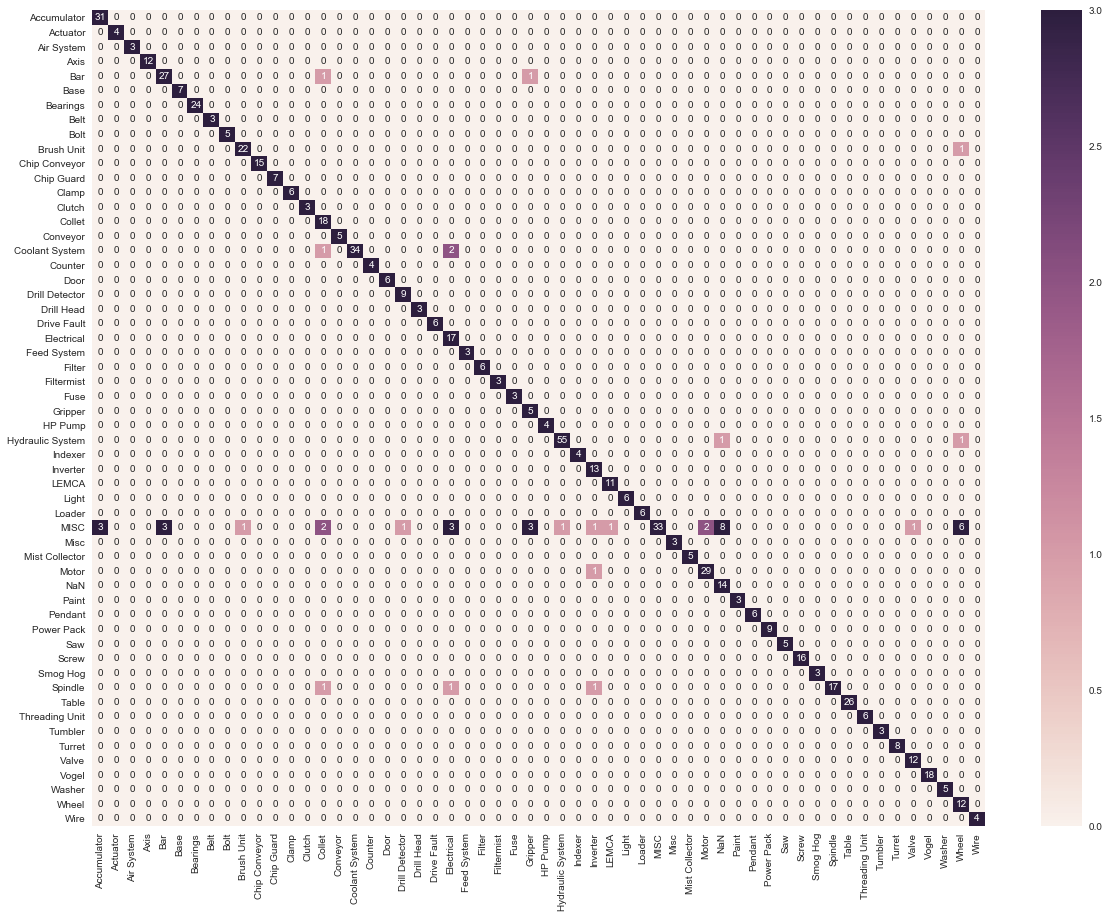

In [89]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df_cnf_w2v, robust=True, annot=True,
           vmin=0, vmax=3)

C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


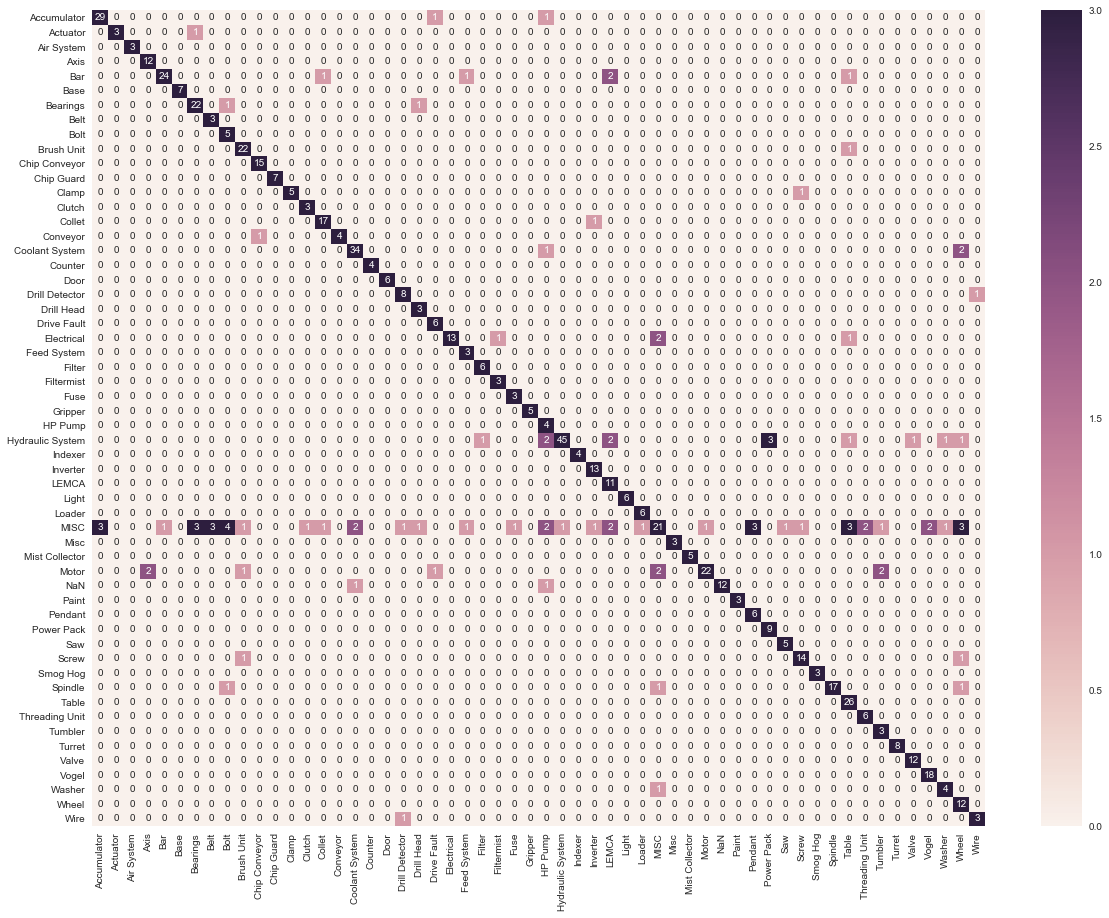

In [90]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df_cnf_lsa, robust=True, annot=True,
           vmin=0, vmax=3)

In [186]:
model_dir = os.path.join('.', 'finished_models')

from sklearn.externals import joblib
#save trained models
joblib.dump(clf_lsa, os.path.join(model_dir, 'SCG_lsa300_AreaPred_Elastic_85pct.pkl'))
joblib.dump(clf_w2v, os.path.join(model_dir, 'SCG_w2v300_AreaPred_Elastic_96pct.pkl'))

#save features
joblib.dump(mini_lsa, os.path.join(model_dir, 'lsa300_VectorEmbed.pkl'))
joblib.dump(mini_w2v, os.path.join(model_dir, 'w2v300_VectorEmbed.pkl'))
joblib.dump(mini_labels, os.path.join(model_dir, 'machinearea_labels.pkl'))

['.\\finished_models\\machinearea_labels.pkl']

In [94]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

X = w2v_embed

connectivity = kneighbors_graph(X, n_neighbors=5, include_self=False)

print("Compute structured hierarchical clustering...")
ward = AgglomerativeClustering(n_clusters=20, connectivity=connectivity,
                               linkage='ward').fit(X)

label = ward.labels_
print("Number of points: %i" % label.size)

# from scipy.cluster.hierarchy import linkage
# links = linkage(X, method='ward')

Compute structured hierarchical clustering...


C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 6 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


Number of points: 3435


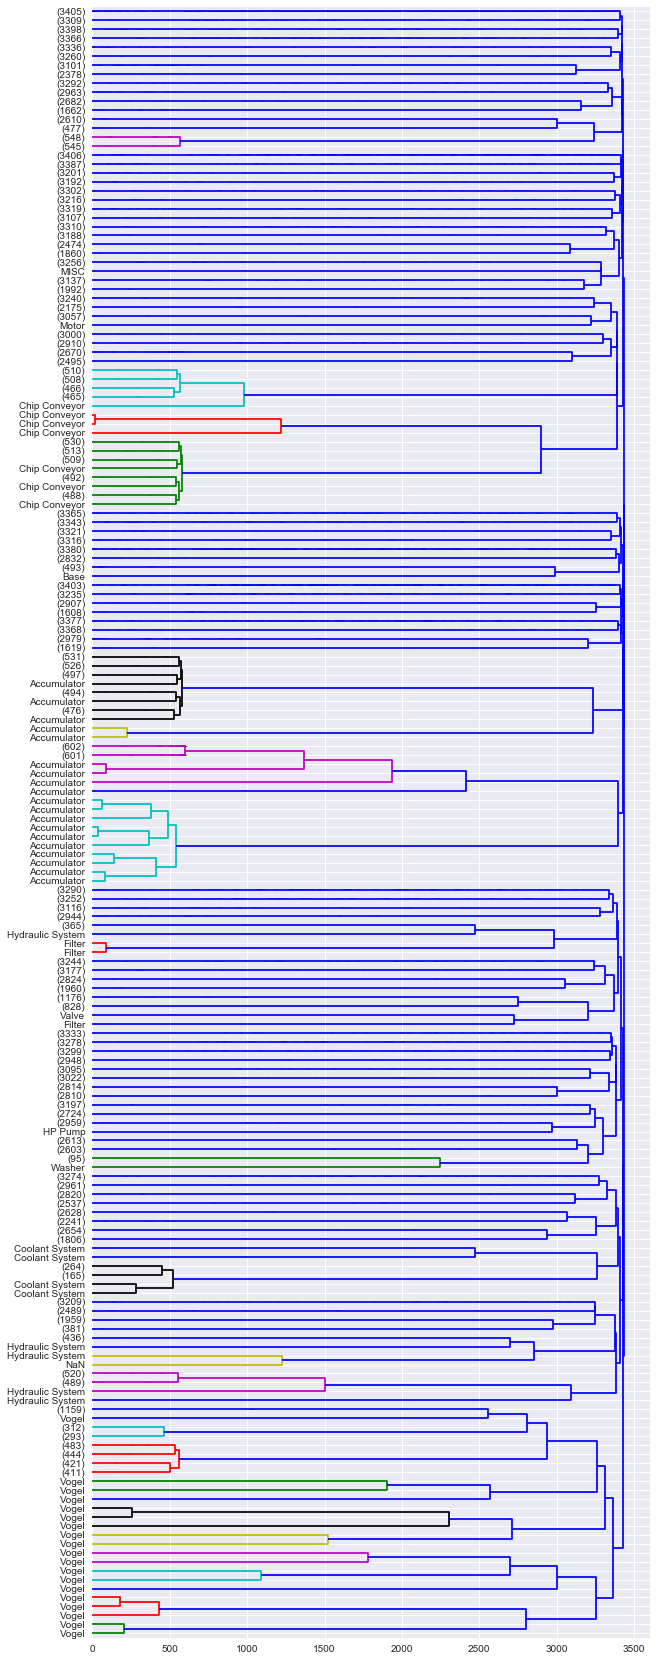

In [96]:
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10,30))
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
plot_dendrogram(ward,
                truncate_mode="level",  # no more than p levels are displayed
                    p=7,  # show only the last p merged clusters
                show_leaf_counts=True,  # numbers in brackets are counts, others idx
                leaf_font_size=10.,
                show_contracted=True,  # to get a distribution impression in truncated branches
                orientation='right',
                labels=df['SCG_w2v_AreaPrediction'].values)